# Mixture of Gaussians experiment using L2HMC

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, \
    get_data, binarize, normal_kl, acl_spectrum, ESS
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Sequential, Zip, Parallel, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.notebook_utils import get_hmc_samples
from utils.logging import variable_summaries

In [1]:
def get_run_num(log_dir):
    if not os.path.isdir(log_dir):
        os.makedirs(log_dir)
    run_dirs = []
    contents = os.listdir(log_dir)
    if contents == ['.DS_Store']:
        return 1
    else:
        for item in contents:
            if os.path.isdir(log_dir + item):
                run_dirs.append(item)
        run_nums = [int(str(i)[3:]) for i in run_dirs]
        prev_run_num = max(run_nums)
        return prev_run_num + 1

def make_run_dir(log_dir):
    if log_dir.endswith('/'):
        _dir = log_dir
    else:
        _dir = log_dir + '/'
    run_num = get_run_num(_dir)
    run_dir = _dir + f'run{run_num}/'
    if os.path.isdir(run_dir):
        raise f'Directory: {run_dir} already exists, exiting!'
    else:
        print(f'Creating directory for new run: {run_dir}')
        os.makedirs(run_dir)
    return run_dir

In [5]:
root_log_dir = './log_mog_tf/'
log_dir = make_run_dir(root_log_dir)

Creating directory for new run: ./log_mog_tf/run22/


## Network architecture

We define the network architecture for our L2HMC network. We first embed the first two variables ($\{x, \partial_x U\}$ or $\{v, x_m\}$) as well as the time, formatted as $\tau(t) = \left(\cos(\frac{2\pi t}{M}), \sin(\frac{2\pi t}{M})\right)$. They are forwarded through an MLP and then produce $S, T$ and $Q$.

In [6]:
def network(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, 10, scope='embed_1', factor=1.0 / 3),
                Linear(x_dim, 10, scope='embed_2', factor=factor * 1.0 / 3),
                Linear(2, 10, scope='embed_3', factor=1.0 / 3),
                lambda _: 0.,
            ]),
            sum,
            tf.nn.relu,
            Linear(10, 10, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(10, x_dim, scope='linear_s', factor=0.001), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(10, x_dim, scope='linear_t', factor=0.001),
                Sequential([
                    Linear(10, x_dim, scope='linear_f', factor=0.001),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])  
        ])
        
    return net

## Distribution

We set up our dynamics which take as input our energy function, the number of time step of our operator, the (learnable) step-size and our architecture.

In [7]:
x_dim = 2
means = [np.array([-4.0, 0.0]).astype(np.float32),
         np.array([4.0, 0.0]).astype(np.float32)]
covs = [np.array([[0.1, 0.0], [0.0, 0.1]]).astype(np.float32),
        np.array([[0.1, 0.0], [0.0, 0.1]]).astype(np.float32)]
distribution = GMM(means, covs, [0.5, 0.5])
# Get some samples from the true distribution for debugging
init_samples = distribution.get_samples(1000)
np.save('init_samples', init_samples)

In [9]:
dynamics = Dynamics(x_dim, distribution.get_energy_function(), 
                    T=10, eps=0.1, net_factory=network, use_temperature=True)

In [10]:
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.random_normal(tf.shape(x))

Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

loss = 0.

v1 = (tf.reduce_sum(tf.square(x - Lx), axis=1) * px) + 1e-4
v2 = (tf.reduce_sum(tf.square(z - Lz), axis=1) * pz) + 1e-4
scale = 0.2
loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
loss += (- tf.reduce_mean(v1, name='v1') 
         - tf.reduce_mean(v2, name='v2')) / scale
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [11]:
global_step = tf.Variable(0., name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 1000, 0.96, 
                                           staircase=True)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss, global_step=global_step)

In [12]:
n_steps = 20000
n_samples = 200
losses = []
samples = np.random.randn(n_samples, x_dim)

In [13]:
summary = tf.summary.merge_all()
init = tf.global_variables_initializer()
saver = tf.train.Saver()
sess = tf.Session()
summary_writer = tf.summary.FileWriter(log_dir, sess.graph)
sess.run(init)
temp = 40  # Initial temperature to be used in annealing schedule

In [20]:
time1 = time.time()

for t in range(n_steps//4):
    feed_dict = {x: samples, 
                 dynamics.temperature: temp}
    
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        output[0],
        px,
        learning_rate,
    ], feed_dict=feed_dict)
    losses.append(loss_)

    if t % 50 == 0:
        step_num = global_step.eval(session=sess) 
        summary_str = sess.run(summary, feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, step_num)
        summary_writer.flush()
        print(f'Step: {step_num} / {n_steps}, Loss: {loss_:.4e}, '
              + f'Acceptance sample: {np.mean(px_):.2f}, LR: {lr_:.5f}, '
              + f'temp: {temp:.5f}')
        if t % 200 == 0:
            temp *= 0.98
    if t % 5000 == 0:
        step_num = global_step.eval(session=sess) 
        checkpoint_file = os.path.join(log_dir, 'model.ckpt')
        print(f'Saving checkpoint to: {checkpoint_file}')
        saver.save(sess, checkpoint_file)
        
time2 = time.time()
dt1 = time2 - time1
print(f'Time to train sampler for {n_steps//2} was {dt1} seconds')

Step: 5001.0 / 20000, Loss: -4.9086e+02, Acceptance sample: 0.81, LR: 0.00082, temp: 24.13859
Saving checkpoint to: ./log_mog_tf/run22/model.ckpt


'./log_mog_tf/run22/model.ckpt'

Step: 5051.0 / 20000, Loss: -4.8135e+02, Acceptance sample: 0.80, LR: 0.00082, temp: 23.65582
Step: 5101.0 / 20000, Loss: -4.8265e+02, Acceptance sample: 0.81, LR: 0.00082, temp: 23.65582
Step: 5151.0 / 20000, Loss: -5.1289e+02, Acceptance sample: 0.85, LR: 0.00082, temp: 23.65582
Step: 5201.0 / 20000, Loss: -5.3718e+02, Acceptance sample: 0.86, LR: 0.00082, temp: 23.65582
Step: 5251.0 / 20000, Loss: -4.8589e+02, Acceptance sample: 0.85, LR: 0.00082, temp: 23.18270
Step: 5301.0 / 20000, Loss: -4.6896e+02, Acceptance sample: 0.74, LR: 0.00082, temp: 23.18270
Step: 5351.0 / 20000, Loss: -4.7361e+02, Acceptance sample: 0.80, LR: 0.00082, temp: 23.18270
Step: 5401.0 / 20000, Loss: -4.8573e+02, Acceptance sample: 0.80, LR: 0.00082, temp: 23.18270
Step: 5451.0 / 20000, Loss: -5.1718e+02, Acceptance sample: 0.85, LR: 0.00082, temp: 22.71905
Step: 5501.0 / 20000, Loss: -5.0422e+02, Acceptance sample: 0.82, LR: 0.00082, temp: 22.71905
Step: 5551.0 / 20000, Loss: -5.0567e+02, Acceptance sample: 

Step: 9451.0 / 20000, Loss: -4.3013e+02, Acceptance sample: 0.74, LR: 0.00069, temp: 15.16742
Step: 9501.0 / 20000, Loss: -4.5078e+02, Acceptance sample: 0.73, LR: 0.00069, temp: 15.16742
Step: 9551.0 / 20000, Loss: -4.4383e+02, Acceptance sample: 0.74, LR: 0.00069, temp: 15.16742
Step: 9601.0 / 20000, Loss: -4.3333e+02, Acceptance sample: 0.75, LR: 0.00069, temp: 15.16742
Step: 9651.0 / 20000, Loss: -4.6618e+02, Acceptance sample: 0.81, LR: 0.00069, temp: 14.86407
Step: 9701.0 / 20000, Loss: -4.7199e+02, Acceptance sample: 0.79, LR: 0.00069, temp: 14.86407
Step: 9751.0 / 20000, Loss: -4.6465e+02, Acceptance sample: 0.78, LR: 0.00069, temp: 14.86407
Step: 9801.0 / 20000, Loss: -4.6531e+02, Acceptance sample: 0.77, LR: 0.00069, temp: 14.86407
Step: 9851.0 / 20000, Loss: -4.6132e+02, Acceptance sample: 0.80, LR: 0.00069, temp: 14.56679
Step: 9901.0 / 20000, Loss: -4.8602e+02, Acceptance sample: 0.84, LR: 0.00069, temp: 14.56679
Step: 9951.0 / 20000, Loss: -4.5468e+02, Acceptance sample: 

After training, we generate $200$ chains for $2000$ steps for evaluation purposes.

In [21]:
final_samples = []
samples1 = distribution.get_samples(n=n_samples)

for t in range(2000):
    final_samples.append(np.copy(samples1))

    feed_dict = {
        x: samples1, dynamics.temperature: 1.0,
    }

    samples1 = sess.run(output[0], feed_dict)

np.save('mogsamples1_with_temp', np.array(final_samples))
L2HMC_samples = np.array(final_samples)

## Try generic HMC

We compute the HMC chains with **auto-correlation spectrums** as well.

In [ ]:
HMC_samples_0 = get_hmc_samples(2, 0.1, distribution.get_energy_function(), sess, steps=2000, samples=samples)

In [ ]:
HMC_samples_1 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_2 = get_hmc_samples(2, 0.3, distribution.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_3 = get_hmc_samples(2, 0.5, distribution.get_energy_function(), sess, steps=2000, samples=samples)

In [ ]:
HMC0 = acl_spectrum(HMC_samples_0, scale=scale)

In [ ]:
scale = np.sqrt(np.trace(covs))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

We can plot auto-correlation.

In [ ]:
xaxis = 10 * np.arange(300)
fig, ax = plt.subplots()
ax.plot(xaxis, L2HMC[:300]/max(L2HMC[:300]), label='L2HMC')
ax.plot(xaxis, HMC0[:300]/max(HMC0[:300]), label='HMC $\epsilon=0.1$')
ax.plot(xaxis, HMC1[:300]/max(HMC1[:300]), label='HMC $\epsilon=0.2$')
ax.plot(xaxis, HMC2[:300]/max(HMC2[:300]), label='HMC $\epsilon=0.3$')
ax.plot(xaxis, HMC3[:300]/max(HMC3[:300]), label='HMC $\epsilon=0.5$')
ax.set_ylabel('Auto-correlation')
ax.set_xlabel('Gradient Computations')
#ax.set_xlim((0, 200))
ax.legend()
fig.tight_layout()
fig.savefig('./auto_correlation_vs_grad_comps_MoG_mixed.png', 
            dpi=400, bbox_inches='tight')
plt.show()

We now compute the **Effective Sample Size** (ESS).

In [ ]:
print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

We can visualize a single chain of both HMC and L2HMC for $500$ time steps.


In [ ]:
fig, ax = plt.subplots()
ax.plot(HMC_samples_0[:100, 1, 0], HMC_samples_0[:100, 1, 1], 
         color='C1', marker='o', alpha=0.8, ls='-')
ax.set_title("Single chain of HMC $(\epsilon = 0.1)$ for 1000 time steps")
fig.tight_layout()
fig.savefig('./MoG_HMC_chain_e01_100t_1.png', dpi=400, bbox_inches='tight')
plt.show()

## Intermediate L2HMC MCMC chains (after 5000 training steps)

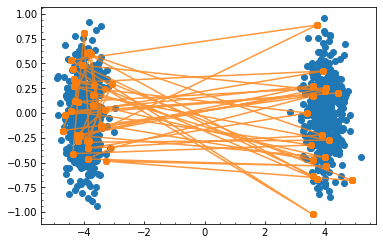

In [23]:
#%matplotlib inline
#for i in range(10, 20):
#    print(f'i: {i}')
fig, ax = plt.subplots()
ax.scatter(init_samples[:,0], init_samples[:,1], color='C0')
ax.plot(L2HMC_samples[:, -i, 0], L2HMC_samples[:, -i, 1], 
        marker='o', color='C1', alpha=0.8)
plt.show()
fig.tight_layout()
out_file = './2D_MoG_trajectory_2000t_10000train_4.png'
fig.savefig(out_file, dpi=400, bbox_inches='tight')